In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tools_ryu import mytool
from multi_run_v2.initialize_v2 import data_pp, make_market_index
from multi_run_v2.momentum_strategy_v3 import *

2023-05-19 10:39:23,112	INFO worker.py:1625 -- Started a local Ray instance.


In [2]:
# Binance Data는 코드 수정해야함
cmktcap = pd.read_pickle("Data/cmktcap_data_final.pickle")
#cmktcap_reduced = pd.read_pickle("Data/cmktcap_data_reduced.pickle")
#binance = pd.read_pickle("Data/binance_data_pp.pickle")

In [3]:
#값들 설정          mktcap, volume
group_value = {#"M0":[1_000_000, None],
               "M1":[1_000_000,1_000_000]}
               #"M2":[1_000_000,5_000_000]}

In [4]:
# Initialize the Data
cmkt_data = data_pp(cmktcap, vender="coinmarketcap")
#cmktre_data = data_pp(cmktcap_reduced, vender="coinmarketcap")
#binance_data = data_pp(binance, vender="binance")

In [5]:
# Ray Data 생성
ray_price = ray.put(cmkt_data["price"])
ray_mktcap = ray.put(cmkt_data["mktcap"])
ray_vol = ray.put(cmkt_data["vol"])

# Binance Data 생성
#ray_price_b = ray.put(binance_data["price"])
#ray_mktcap_b = ray.put(binance_data["mktcap"])
#ray_vol_b = ray.put(binance_data["vol"])

In [ ]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)

In [ ]:
# Ray Data 생성
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

# 1. Market Index 생성

In [ ]:
# 코인 마켓 인덱스 생성  리턴값 -> mkt_index, time_series_coin_num
market_index_cmkt = {}

mkt_future = [make_market_index.remote(price_df=ray_price,
                                       mktcap_df=ray_mktcap,
                                       vol_df=ray_vol,
                                       mktcap_thresh=value_lst[0],
                                       vol_thresh=value_lst[1],
                                       ma=True) 
              for key, value_lst in group_value.items()]

mkt_result = ray.get(mkt_future)

In [ ]:
mkt_result_dict = {#"M0":mkt_result[0],
                   "M1":mkt_result[0],}
                   #"M2":mkt_result[2],}
                   #"M4":mkt_result[3]}

In [ ]:
mytool.draw_return_result(mkt_result_dict, 
                          title="",
                          log=False)

In [ ]:
mkt_result_dict["M2"]

In [ ]:
mytool.print_statistics(mkt_result_dict)

# 2. 모멘텀 전략 (Value Weighted)

In [ ]:
days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [ ]:
momentum_cmkt = {}

momentum_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                         mktcap_df=ray_mktcap,
                                                         vol_df=ray_vol,
                                                         n_group=num,
                                                         day_of_week="SUN",
                                                         number_of_coin_group=20,
                                                         mktcap_thresh=1_000_000,
                                                         vol_thresh=1_000_000,
                                                         fee_rate=0.0015,
                                                         freq="Daily") 
                   
              for num in [2,3,4,5]]

momentum_result = ray.get(momentum_future)

In [ ]:
momentum_result_dict = {"2":momentum_result[0],
                        "3":momentum_result[1],
                        "4":momentum_result[2],
                        "5":momentum_result[3]}

In [ ]:
momentum_result[0]["LS-cross"]

In [ ]:
vs_mkt = {"LS-cross":momentum_result[3]["LS-cross"],
          "Market":mkt_result_dict["M1"].loc["2017-12-02":]}
mytool.draw_return_result(vs_mkt, 
                          title="",
                          log=True,
                          one_plot=True)

In [ ]:
mytool.print_statistics(vs_mkt)

In [ ]:
mytool.draw_return_result(momentum_result_dict["5"], 
                          title="",
                          log=True)

In [ ]:
for i in [2,3,4,5]:
    print(i)
    print(mytool.print_statistics(momentum_result_dict[f"{i}"]))

In [ ]:
what = "Long_Q5"

a = {"M0":momentum_result_dict["M0"][what].loc["2017-12-31":],
"M1":momentum_result_dict["M1"][what].loc["2017-12-31":],
"M2":momentum_result_dict["M2"][what].loc["2017-12-31":]}

In [ ]:
mytool.print_statistics(a)

In [ ]:
mytool.draw_return_result(a, title=f"{what} Result 2018~", log=True,
                          one_plot=True)

Binance

In [ ]:
# Binance Data
momentum_binance = {}
momentum_future_binance = [weekly_momentum_value_weighted.remote(price_df=ray_price_b,
                                                                 mktcap_df=ray_mktcap_b,
                                                                 vol_df=ray_vol_b,
                                                                 n_group=4,
                                                                 day_of_week="SUN",
                                                                 number_of_coin_group=10,
                                                                 mktcap_thresh=value_lst[0],
                                                                 vol_thresh=value_lst[1],
                                                                 fee_rate=0.0015) 
                          for key, value_lst in group_value.items()]

momentum_result_b = ray.get(momentum_future_binance)

In [ ]:
momentum_result_dict_b = {"M0":momentum_result_b[0],
                        "M1":momentum_result_b[1],
                        "M2":momentum_result_b[2]}

In [ ]:
mytool.draw_return_result(momentum_result_dict_b["M1"], 
                          title="",
                          log=False)

# 3. Value Weighted, Marketcap Capped 

In [ ]:
momentum_capped_future = [weekly_momentum_value_weighted_capped.remote(price_df=ray_price,
                                                         mktcap_df=ray_mktcap,
                                                         vol_df=ray_vol,
                                                         n_group=num,
                                                         day_of_week="SUN",
                                                         number_of_coin_group=20,
                                                         mktcap_thresh=1_000_000,
                                                         vol_thresh=1_000_000,
                                                         fee_rate=0.0015,
                                                         freq="Daily",
                                                         num_cap=20) 
                   
              for num in [2,3,4,5]]

momentum_capped_result = ray.get(momentum_capped_future)

In [ ]:
momentum_capped_result_dict = {"2":momentum_capped_result[0],
                               "3":momentum_capped_result[1],
                               "4":momentum_capped_result[2],
                               "5":momentum_capped_result[3],}
                               #"M4":momentum_capped_result[3]}

In [ ]:
mytool.draw_return_result(momentum_capped_result_dict["M2"], 
                          title="",
                          log=True)

In [ ]:
for i in [2,3,4,5]:
    print(i)
    print(mytool.print_statistics(momentum_capped_result_dict[f"{i}"]))

In [ ]:
b = {"M0":momentum_capped_result_dict["M0"]["Long-Short"].loc["2018":],
"M1":momentum_capped_result_dict["M1"]["Long-Short"].loc["2018":],
"M2":momentum_capped_result_dict["M2"]["Long-Short"].loc["2018":]}

In [ ]:
mytool.draw_return_result(b,
                          title="Long-Short After 2018~",
                          log=False,
                          one_plot=True)

In [ ]:
mytool.print_statistics(b)

# 4. 모멘텀 전략 (Momentum Weighted) 

In [15]:
momentum_weighted_cmkt = {}

momentum_weighted_future = [weekly_momentum_volume_weighted_capped.remote(price_df=ray_price,
                                                                    mktcap_df=ray_mktcap,
                                                                    vol_df=ray_vol,
                                                                    n_group=num,
                                                                    day_of_week="SUN",
                                                                    number_of_coin_group=20,
                                                                    mktcap_thresh=1_000_000,
                                                                    vol_thresh=1_000_000,
                                                                    fee_rate=0.0015,
                                                                    num_cap=20,
                                                                    freq="Daily") 
              for num in [2,3,4,5]]

momentum_weighted_result = ray.get(momentum_weighted_future)

In [12]:
momentum_weighted_result_dict = {"1":momentum_weighted_result[0]}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

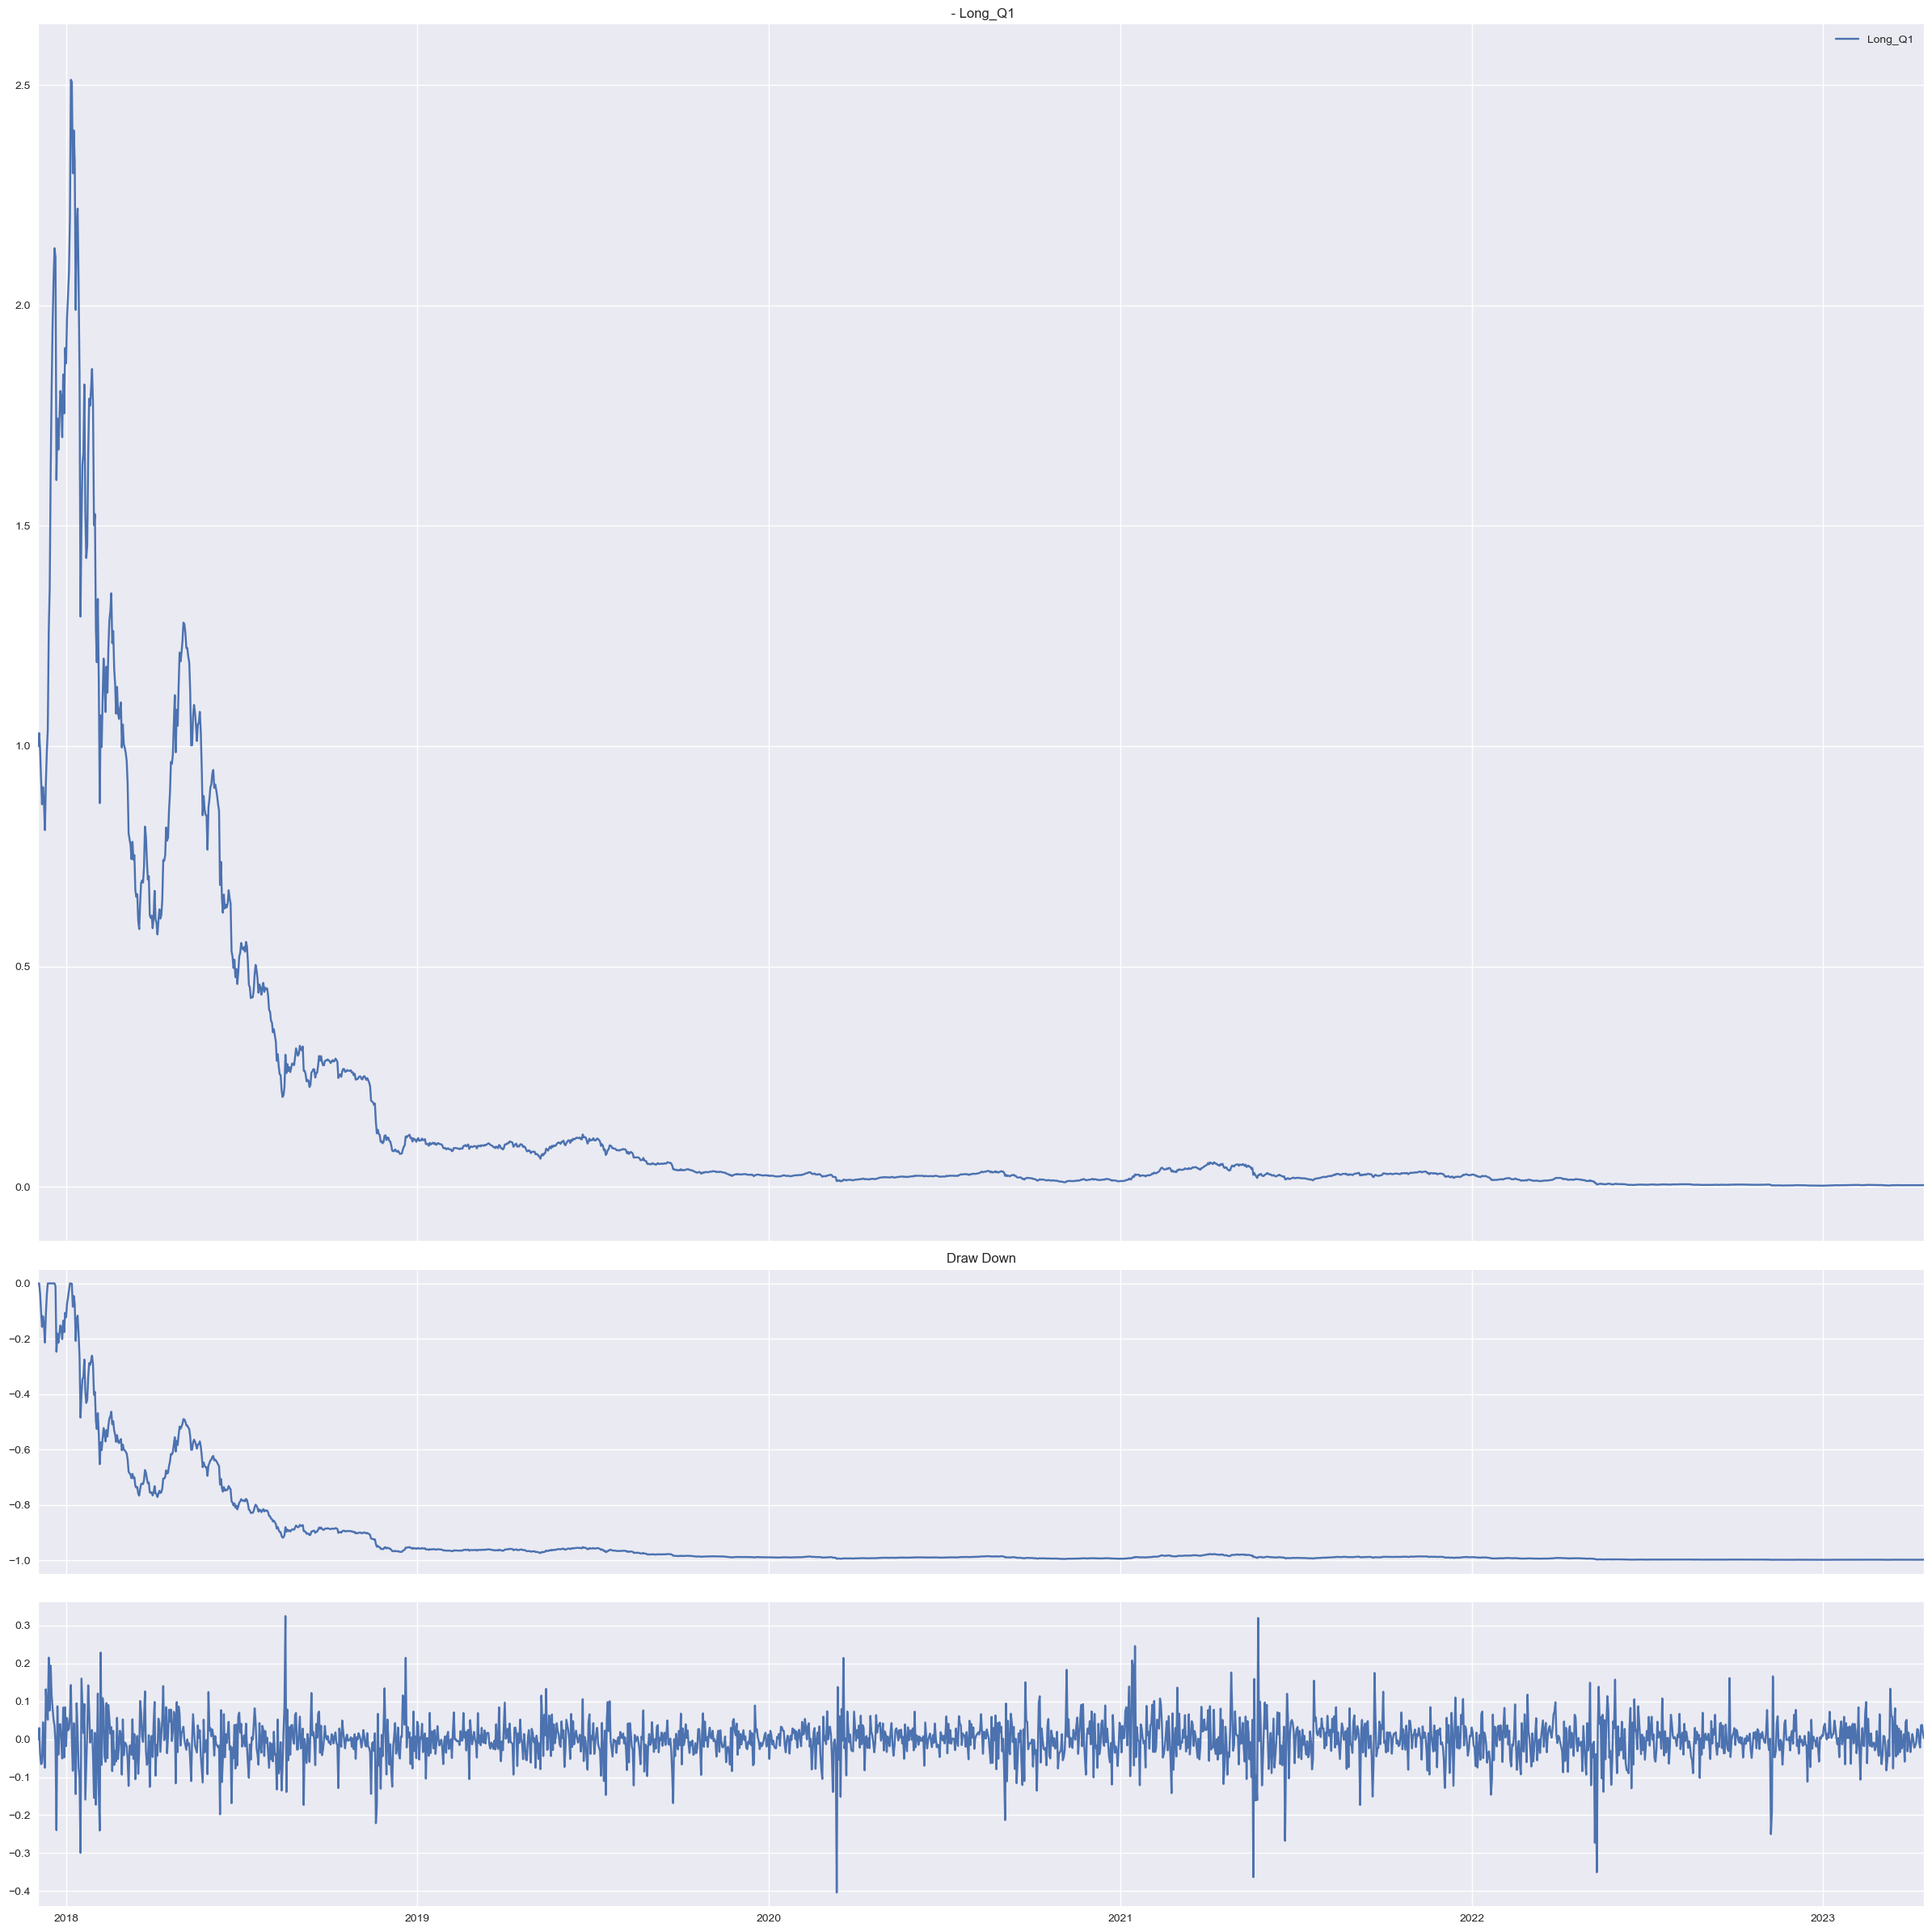

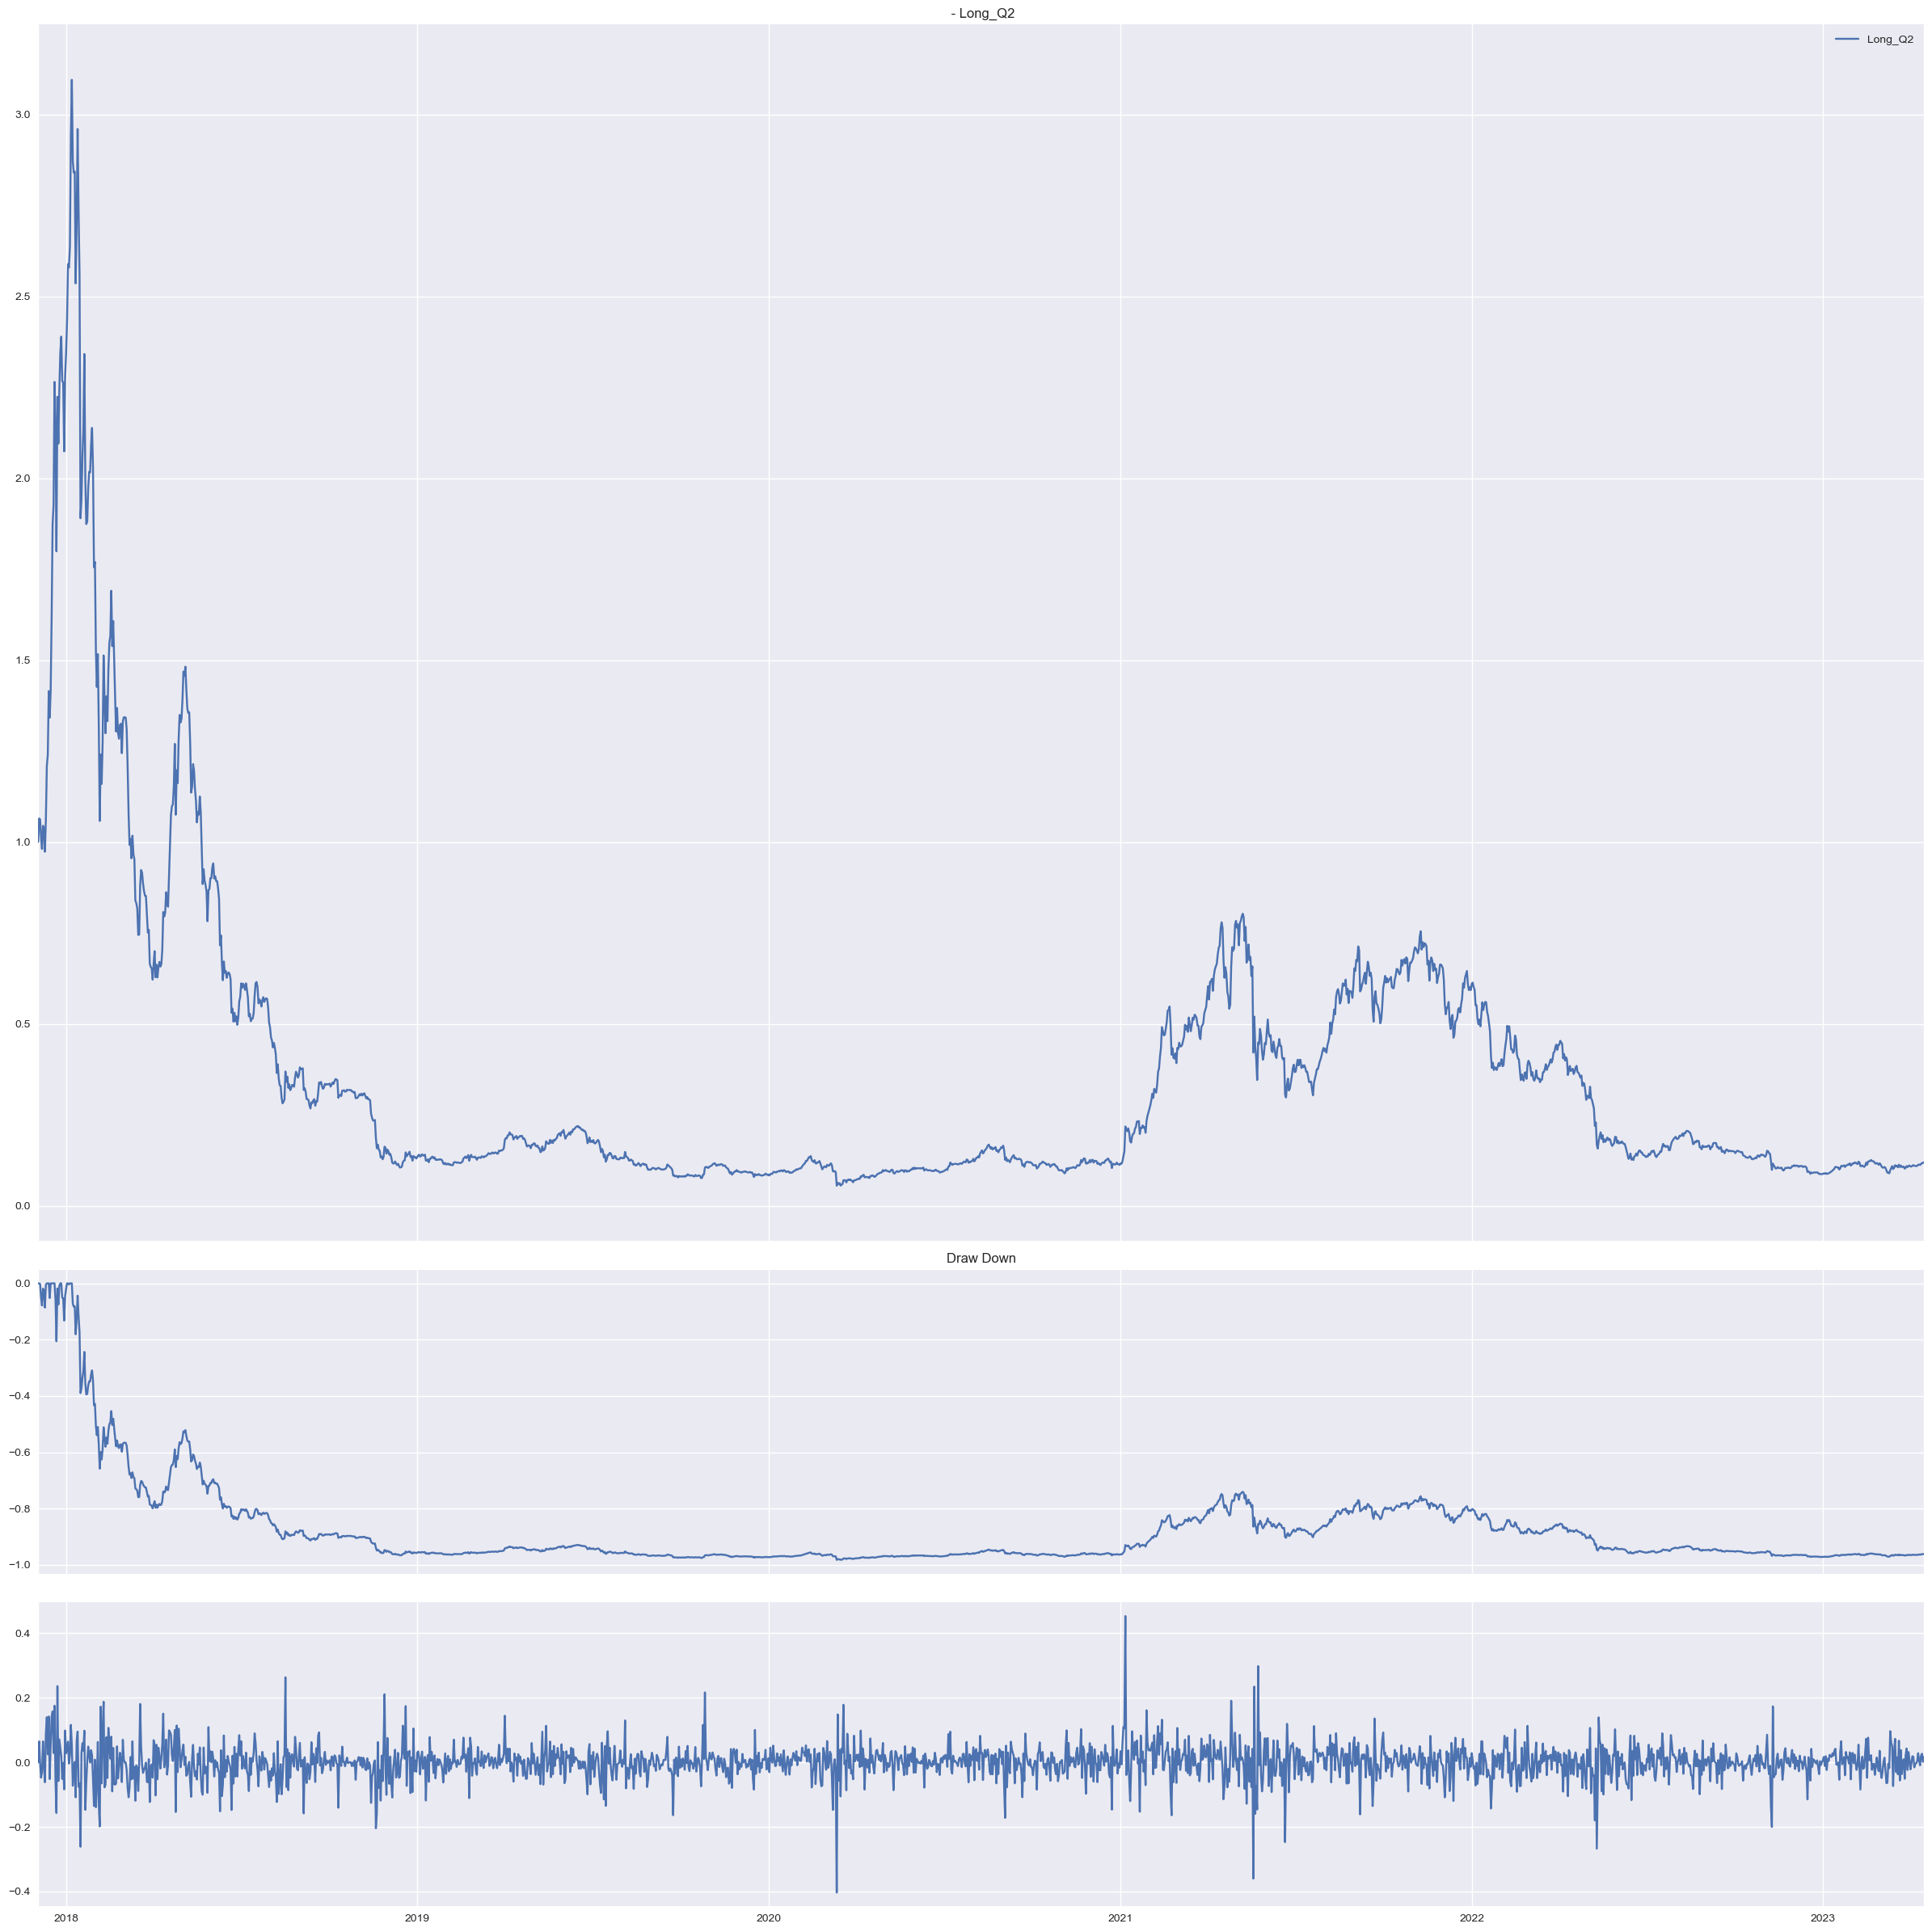

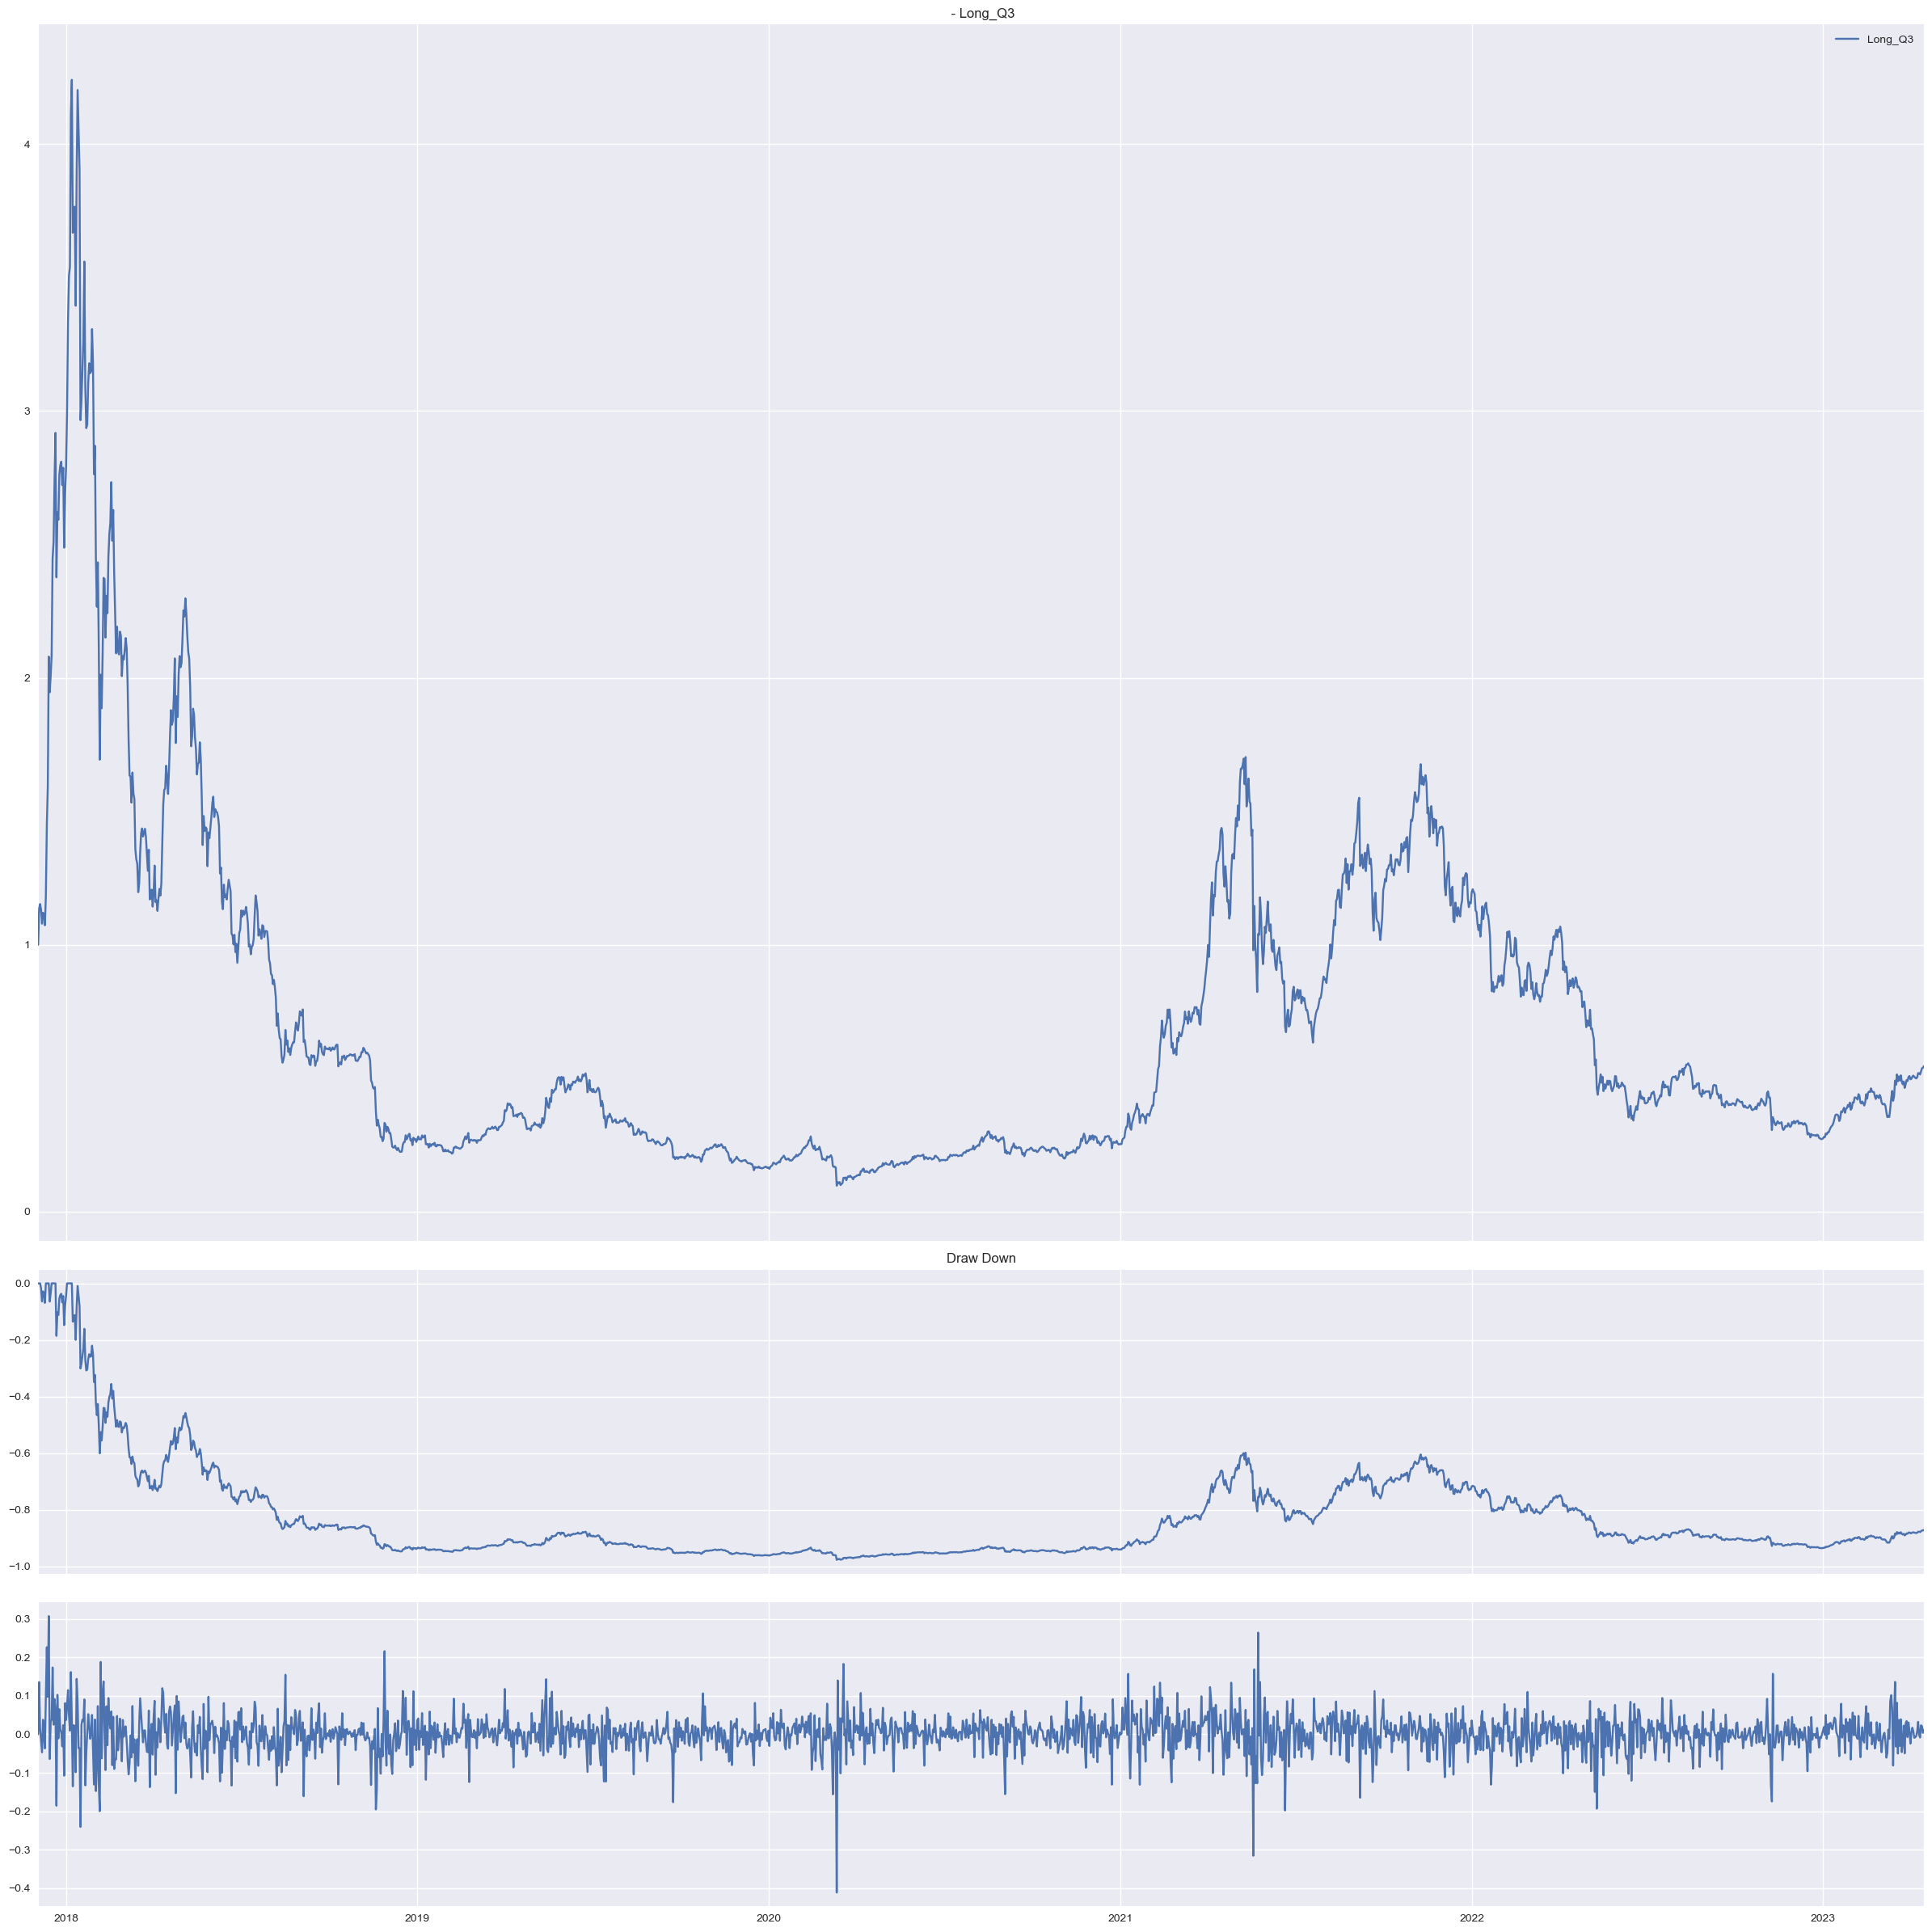

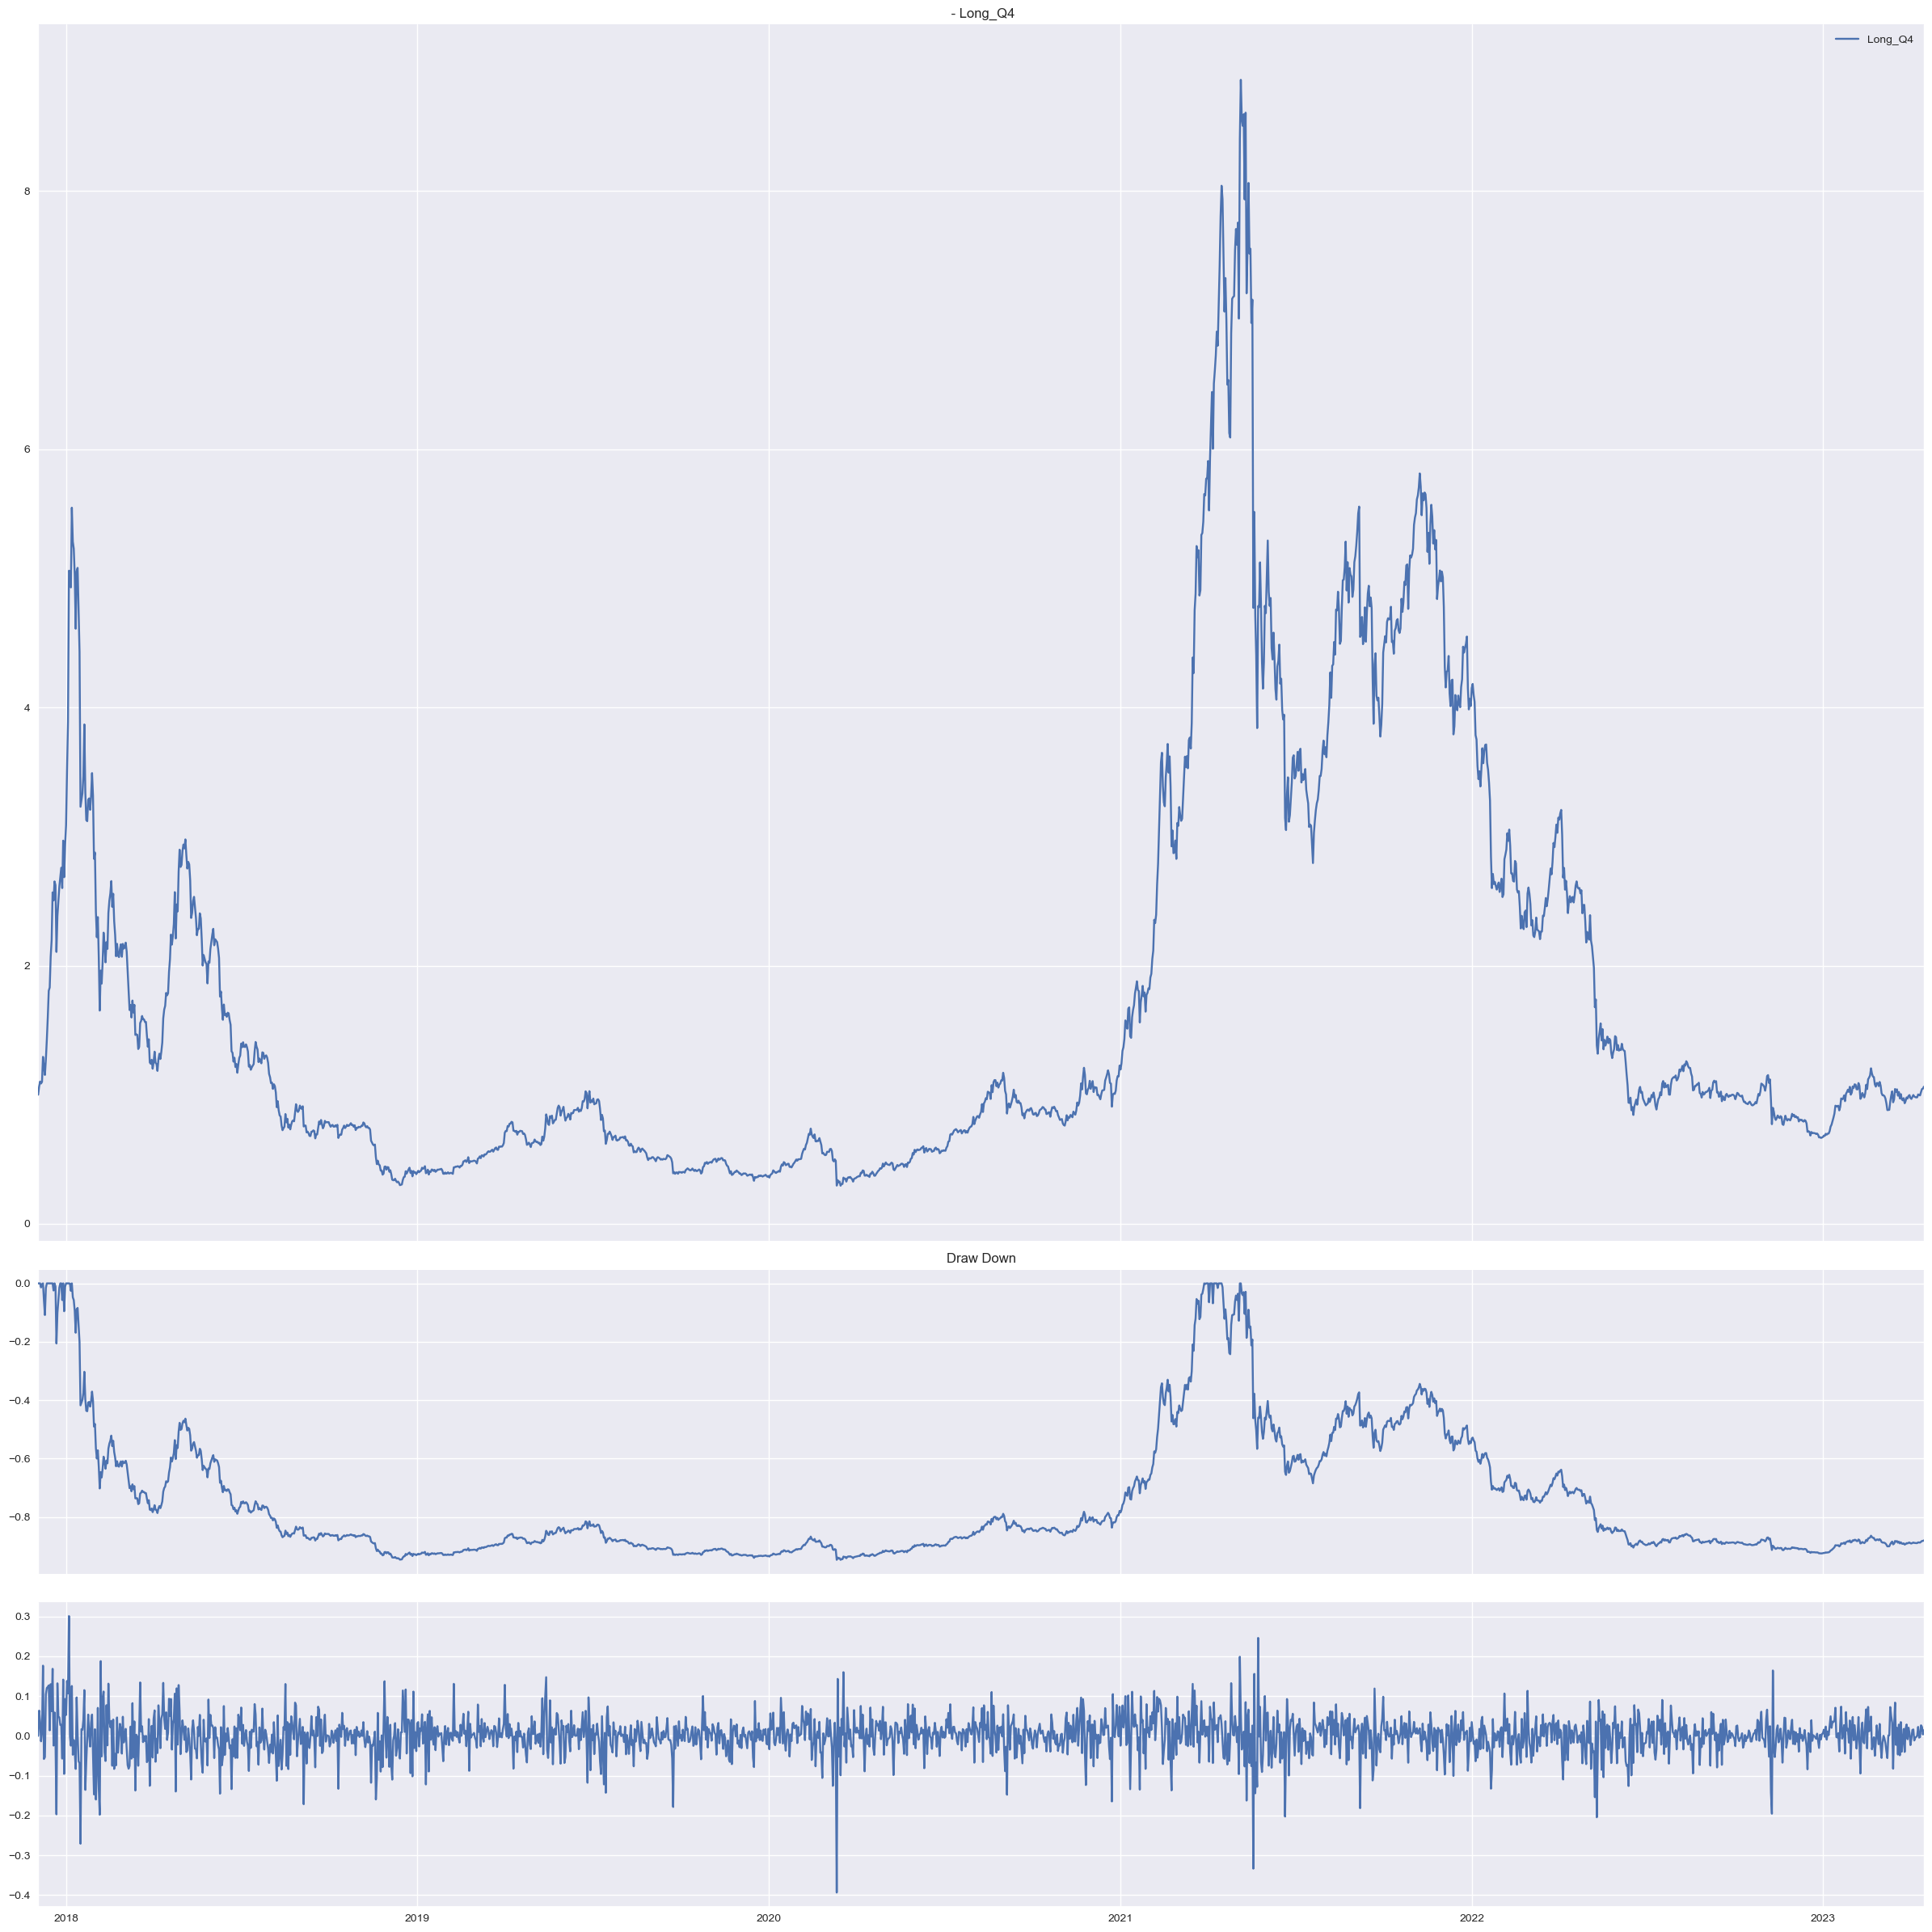

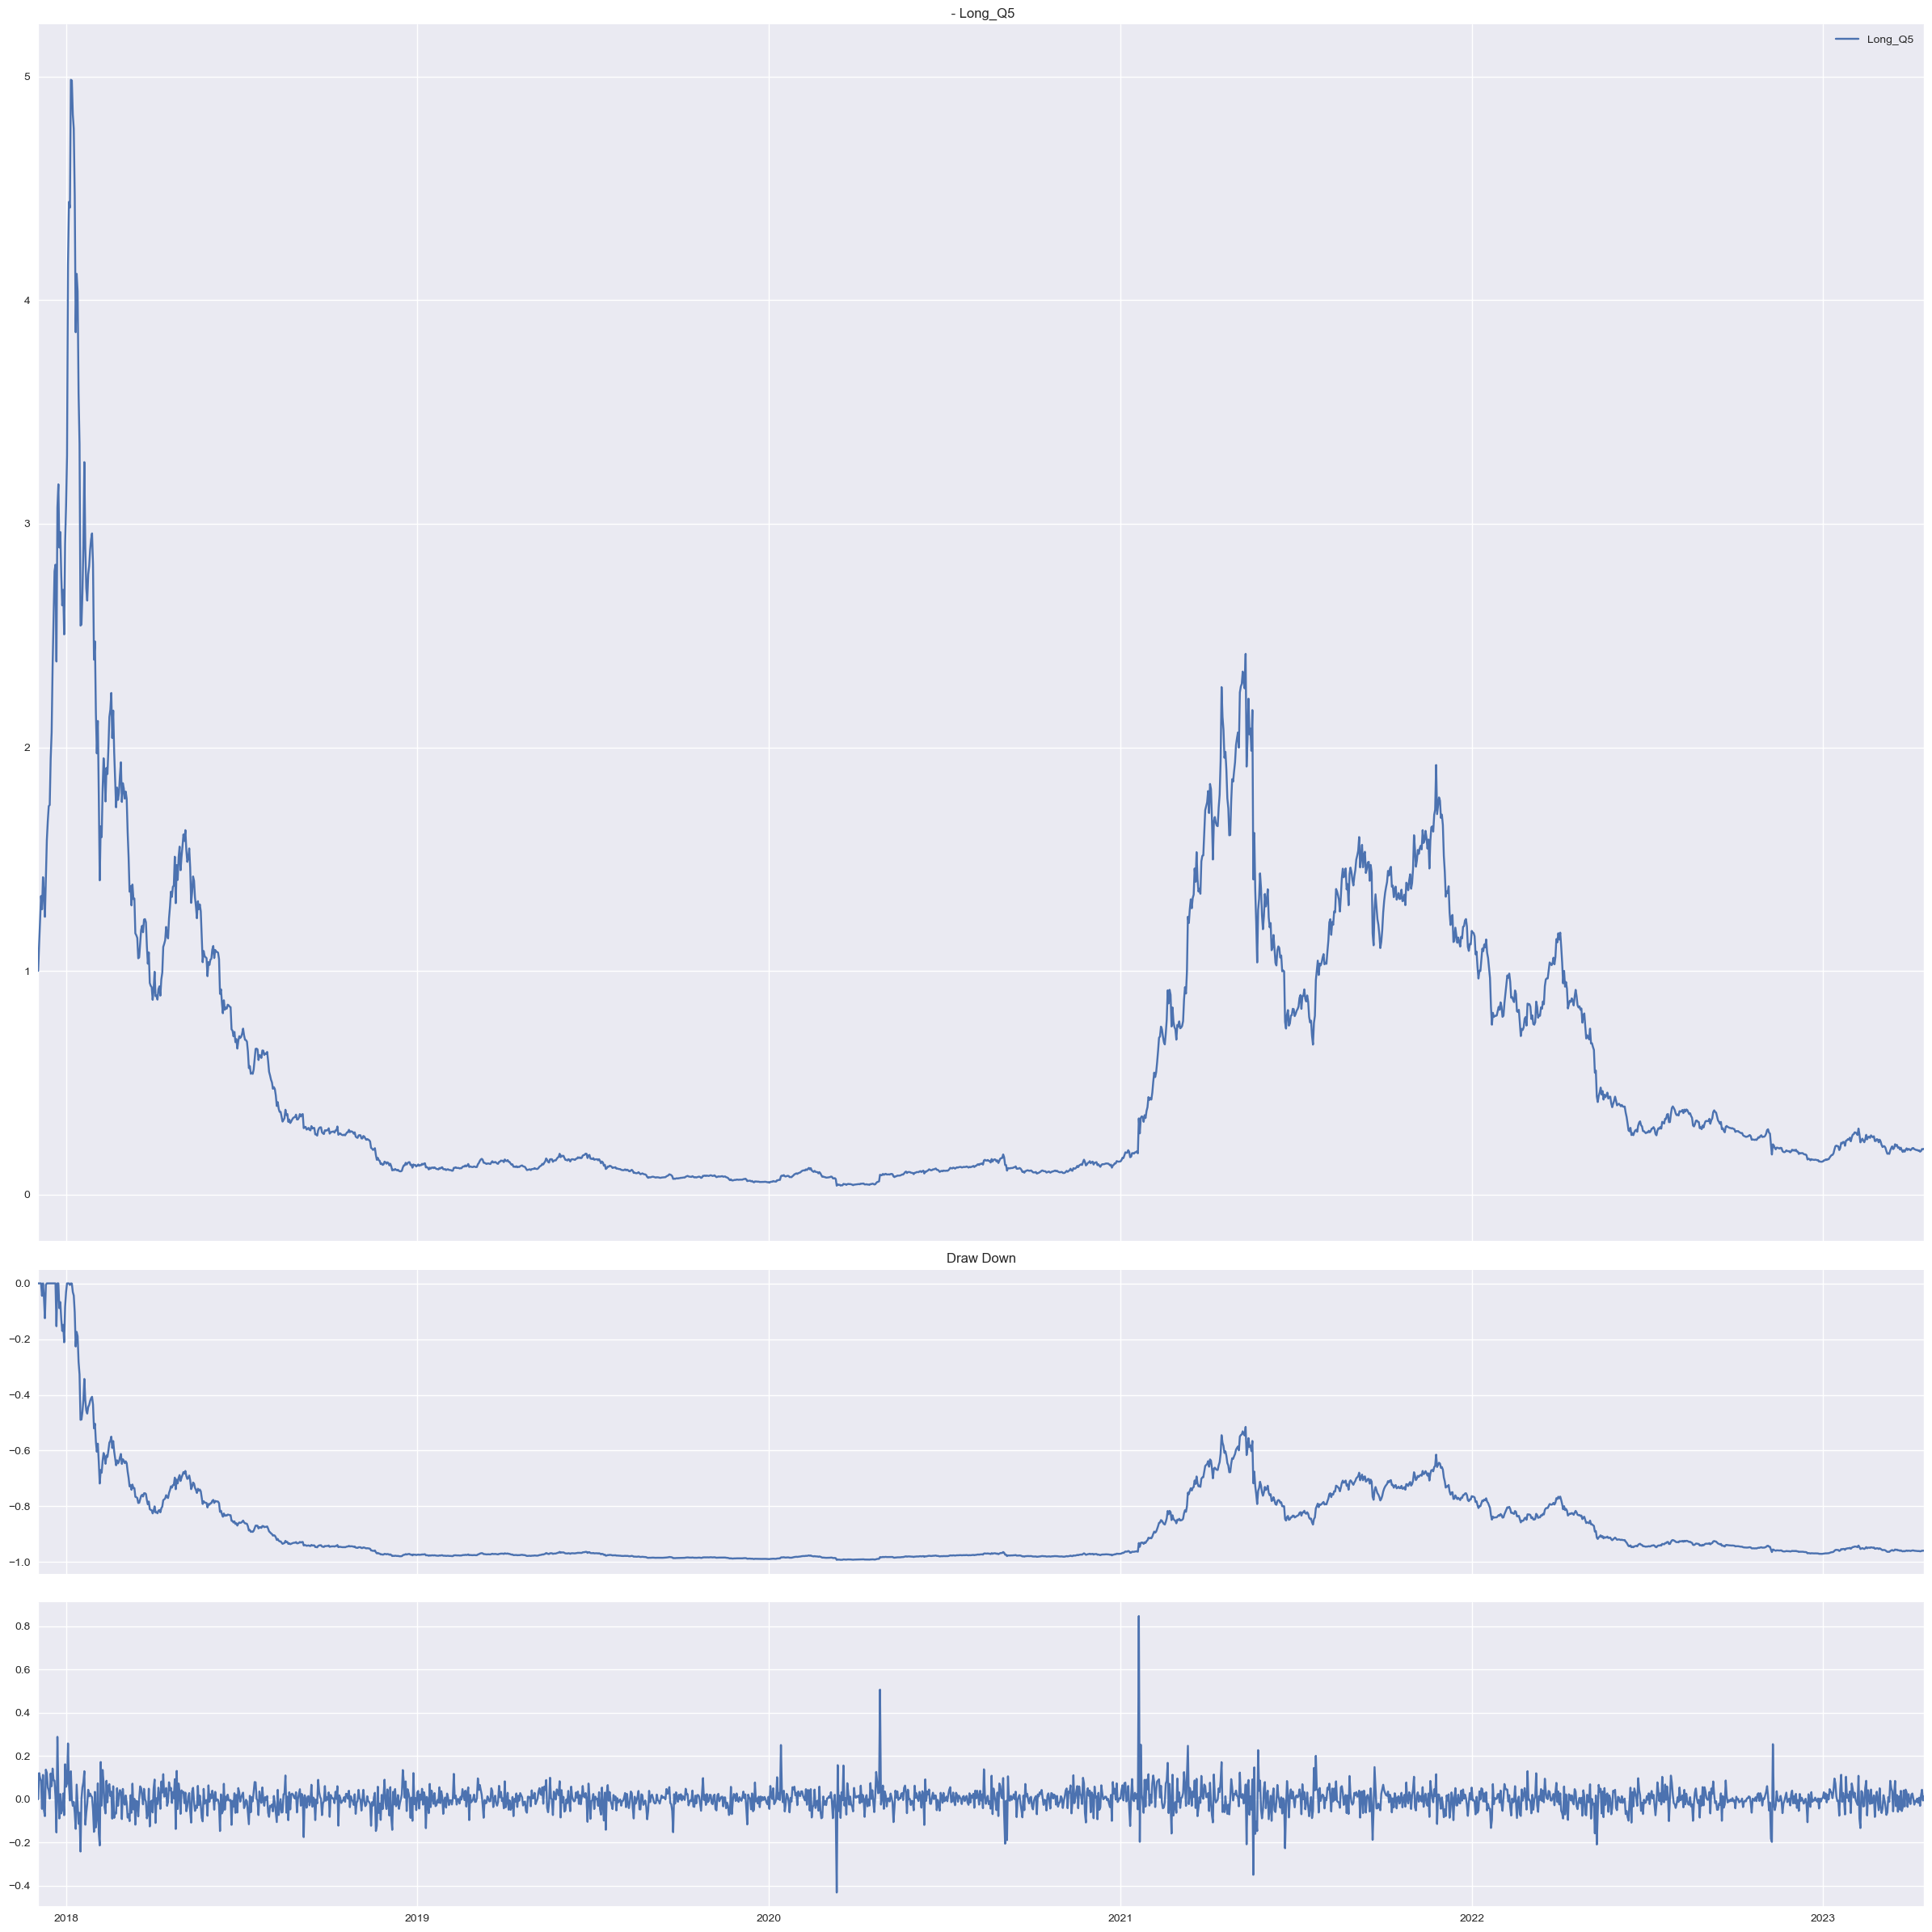

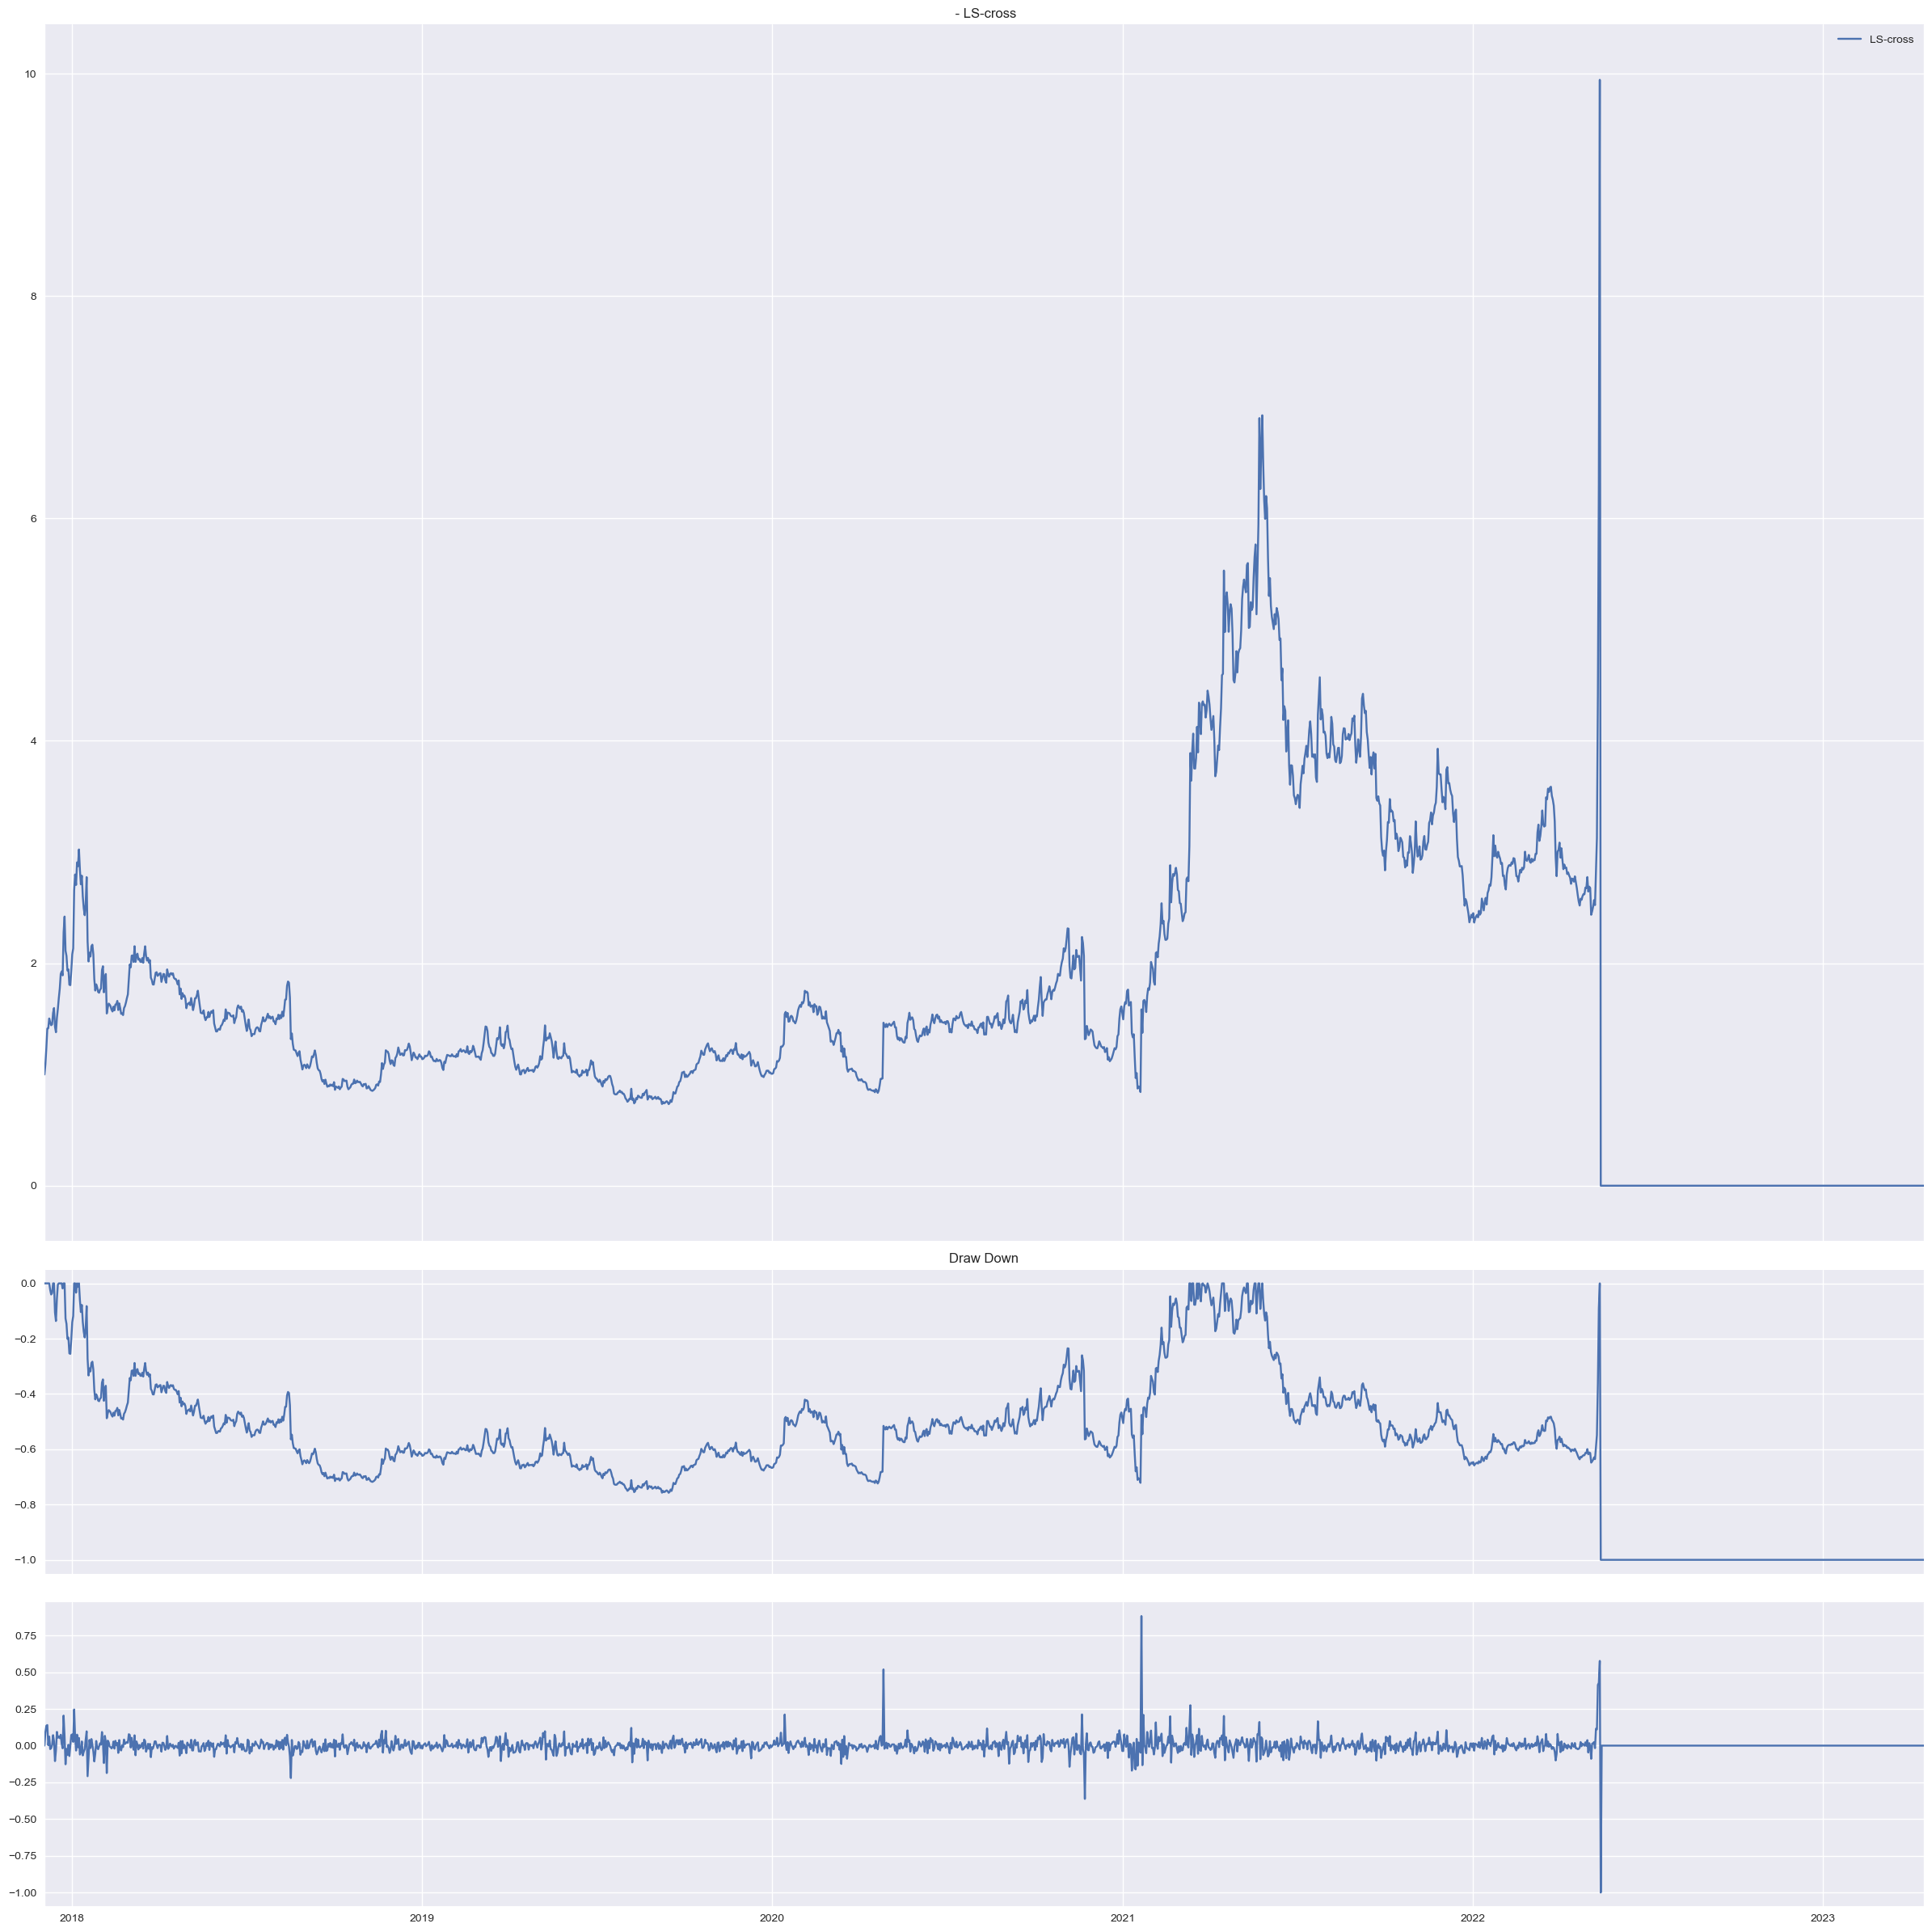

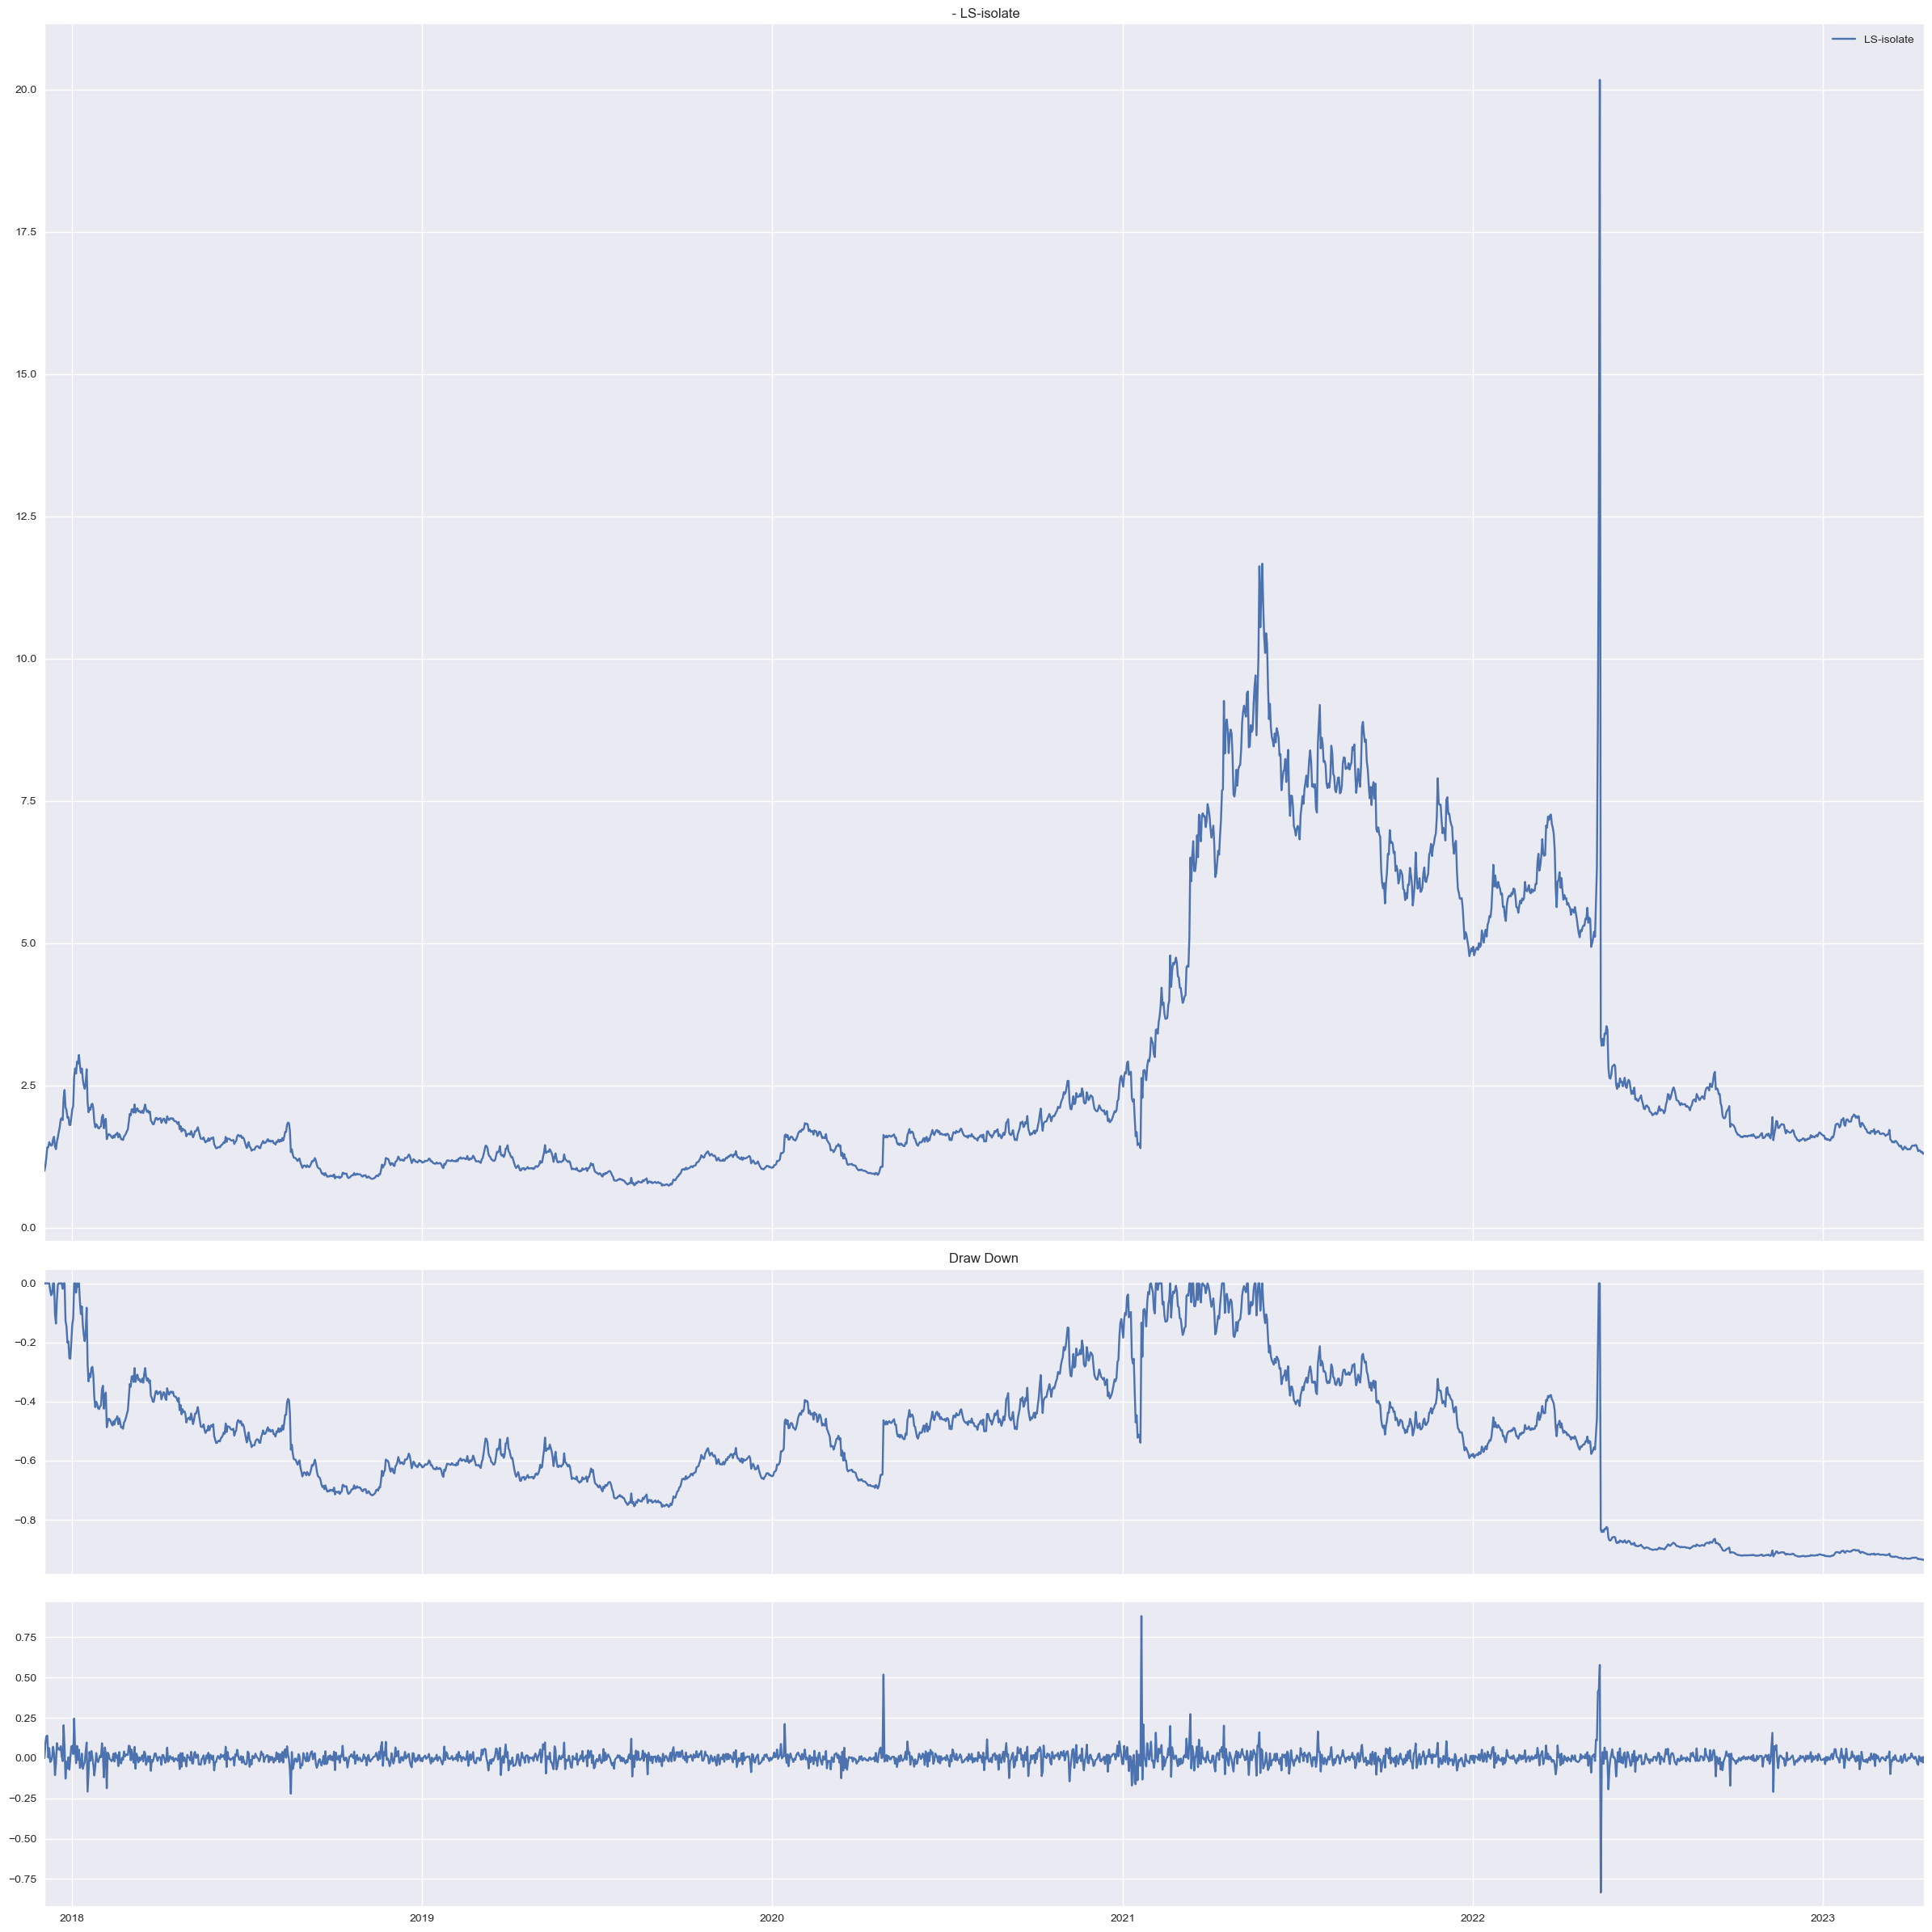

In [13]:
mytool.draw_return_result(momentum_weighted_result_dict["M1"], 
                          title="",
                          log=False);

In [ ]:
mytool.print_statistics(momentum_weighted_result_dict["M3"])

# 5. 모멘텀 전략 Weight Capped (Momentum Weighted) 

In [ ]:
momentum_weighted_capped_cmkt = {}

momentum_weighted_capped_future = [weekly_momentum_momentum_weighted_capped.remote(price_df=ray_price,
                                                                                   mktcap_df=ray_mktcap,
                                                                                   vol_df=ray_vol,
                                                                                   n_group=5,
                                                                                   day_of_week="SUN",
                                                                                   number_of_coin_group=20,
                                                                                   mktcap_thresh=value_lst[0],
                                                                                   vol_thresh=value_lst[1],
                                                                                   fee_rate=0.0015,
                                                                                   num_cap=5) 
              for key, value_lst in group_value.items()]

momentum_weighted_capped_result = ray.get(momentum_weighted_capped_future)

In [ ]:
momentum_weighted_capped_result_dict = {"M1":momentum_weighted_capped_result[0],
                                        "M2":momentum_weighted_capped_result[1],
                                        "M3":momentum_weighted_capped_result[2],
                                        "M4":momentum_weighted_capped_result[3]}

In [ ]:
mytool.draw_return_result(momentum_weighted_capped_result_dict["M4"], 
                          title="",
                          log=False);

In [ ]:
mytool.print_statistics(momentum_weighted_capped_result_dict["M4"])